In [42]:
import numpy as np
from pprint import pprint
from scipy.optimize import leastsq
import matplotlib.pyplot as plt

class Camera(object):
    '''Reduce the misfit between the projection of the GCPs and their identified location in the image.
       Adjust the pose s.t. the squared difference between the projection of the GCP and its location
       in the image is minimized.
       Project the GCPs onto the sensor.
       Recall: Guess at pose vector.
       Then, reduce the misfit between the GCP coordinates that we predicted
       using our guessed-at coordinates, and the true coordinates.'''
    
    def __init__(self, focal_length=None, sensor_x=None, sensor_y=None, pose=None):
        self.p = pose # Pose: x, y, z, phi, theta, psi
        self.focal_length = focal_length                   # Focal Length in Pixels
        self.sensor_x = sensor_x
        self.sensor_y = sensor_y
        
    def projective_transform(self, X):
        """  
        This function performs the projective transform on generalized coordinates in the camera reference frame.
        Expects x, y, z (non-generalized).
        """
        x = X[:, 0]/X[:, 2]
        y = X[:, 1]/X[:, 2]
        u = self.focal_length*x + self.sensor_x / 2
        v = self.focal_length*y + self.sensor_y / 2 # the coordinates that input intensities map to
        u = np.hstack(u)
        v = np.hstack(v)
        return u, v
    
    def rotational_transform(self, X):
        '''Expects non-homogeneous coordinates.'''
        s = np.sin
        c = np.cos
        X_h = np.zeros((X.shape[0], X.shape[1]+1))
        X_h[:, :X.shape[1]] = X
        X_h[:, 3] = np.ones((X.shape[0]))
        X_cam = self.p
        phi = X_cam[3]
        theta = X_cam[4]
        p = X_cam[5]
        trans = np.mat(([1, 0, 0, -X_cam[0]], [0, 1, 0, -X_cam[1]], 
                          [0, 0, 1, -X_cam[2]], [0, 0, 0, 1]))
        r_yaw = np.mat(([c(phi), -s(phi), 0, 0], [s(phi), c(phi), 0, 0], [0, 0, 1, 0]))
        r_pitch = np.mat(([1, 0, 0], [0, c(theta), s(theta)], [0, -s(theta), c(theta)]))
        r_roll = np.mat(([c(p), 0, -s(p)], [0, 1, 0], [s(p), 0, c(p)]))
        r_axis = np.mat(([1, 0, 0], [0, 0, -1], [0, 1, 0]))
        C = r_axis @ r_roll @ r_pitch @ r_yaw @ trans
        Xt = C @ X_h.T
        return Xt.T
    
    def _func(self, x, p):
        self.p = p
        X = self.rotational_transform(x)
        u, v = self.projective_transform(X)
        u = u.T
        v = v.T
        z = np.asarray(np.hstack((u, v)))
        return z.ravel()
    
    def _errfunc(self, p, x, y, func, err):
        xx = func(x, p)
        ss = y.ravel() - xx
        return ss
    
    def estimate_pose(self, X_gcp, u_gcp):
        """
        This function adjusts the pose vector such that the difference between the observed pixel coordinates u_gcp 
        and the projected pixels coordinates of X_gcp is minimized.
        """
        err = np.ones(X_gcp.shape)
        out = leastsq(self._errfunc, self.p, args=(X_gcp, u_gcp, self._func, err), full_output=1)
        return out[0]



In [47]:

f_length = 1.6 * 55 # from canon.com

img_width = 4272
img_height = 2848
focal_length = f_length/36*img_width

sensor_y = img_height
sensor_x = img_width
pose = [272008, 5133938, 90, np.pi/4, 0, 0]

focal_length_ = (55 / 22.2) * 4272 # from canon

coords = np.loadtxt('coordinates.txt', delimiter=',')

u_gcp = coords[:, :2]
X_gcp = coords[:, 2:]

c = Camera(focal_length=focal_length, sensor_x=sensor_x, sensor_y=sensor_y, pose=pose)

p_estimated = c.estimate_pose(X_gcp, u_gcp)
print(p_estimated)

[2.72998137e+05 5.19530398e+06 9.86334756e+02 1.70495037e+00
 2.73551287e-01 1.01605329e-01]


(1, 5)


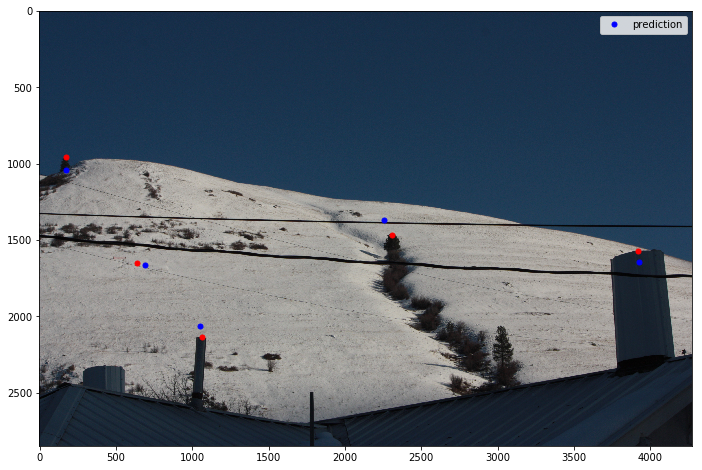

In [64]:
im = plt.imread('IMG_0433.JPG')

u = coords[:, 0]
v = coords[:, 1]

c = Camera(focal_length=focal_length, sensor_x=sensor_x, sensor_y=sensor_y, pose=p_estimated)

X = coords[:, 2:]
Xt = c.rotational_transform(X)
u_c, v_c = c.projective_transform(Xt)
print(u_c.shape)
u_c = np.reshape(u_c, (u_c.shape[1], 1))
v_c = np.reshape(v_c, (v_c.shape[1], 1))


plt.figure(figsize=(12, 8))
plt.imshow(im)
plt.plot(u, v, 'r.', ms=10)
plt.plot(u_c, v_c,'b.', ms=10, label='prediction')
plt.legend()
plt.show()

